<a href="https://colab.research.google.com/github/Huebr/Metodos-de-otimizacao-restrita/blob/main/projeto3_on_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Programação Não Linear - Terceiro Projeto Computacional
**Universidade Federal do Ceará**
Professor: RICARDO COELHO
Alunos: MARCIO BARROS OLIVEIRA DE SOUZA, 
        PAULINO CARDIAL RABELO e 
        PEDRO JORGE DE ABREU FIGUEREDO

#Introdução

Este trabalho consiste no desenvolvimento computacional de métodos de otimização não linear restrita. Dentre eles apresentamos o Método de Barreira e Penalidade. Primeiramente, apresentamos um pouco sobre o ambiente computacional usado. Em seguida, mostramos a implementação dos métodos em conjunto com um breve resumo de cada um deles. Nas seções "Modo de Usar" e "Parâmetros dos Métodos" mostramos como chamar os métodos e quais os parâmetros implementados. Por fim, fazemos um análise simples encima de um conjunto de dados disponibilizados para o desenvolvimento desta atividade.


#Instalação Ambiente

No desenvolvimento desta atividade íremos utilizar Julia como linguagem de implementação pelo seu facil uso e vasto conjunto de bibliotecas que oferecem suporte a otimização matemática. Para facilitar a distribuição fornecemos um notebook Jupyter que colocamos pode ser usado no Colab Google. Veja que facilmente podemos exportar o mesmo para o uso local.

Para podermos executar corretamente no ambiente Colab temos que executar a seguinte célula e reiniciar a aba do navegador aplicando "F5" quando a célula terminar de instalar o kernel Julia. No caso do uso local basta ter a aplicação Jupyter Notebook (,no Windows Anaconda) e uma distribuição Julia 1.4.2 ou mais recente.

In [ ]:
# Installation cell
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.4/julia-1.4.2-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'
echo 'Done'

--2020-10-30 18:42:57--  https://julialang-s3.julialang.org/bin/linux/x64/1.4/julia-1.4.2-linux-x86_64.tar.gz
Resolving julialang-s3.julialang.org (julialang-s3.julialang.org)... 151.101.2.49, 151.101.66.49, 151.101.130.49, ...
Connecting to julialang-s3.julialang.org (julialang-s3.julialang.org)|151.101.2.49|:443... connected.
HTTP request sent, awaiting response... 302 gce internal redirect trigger
Location: https://storage.googleapis.com/julialang2/bin/linux/x64/1.4/julia-1.4.2-linux-x86_64.tar.gz [following]
--2020-10-30 18:42:57--  https://storage.googleapis.com/julialang2/bin/linux/x64/1.4/julia-1.4.2-linux-x86_64.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.73.208, 172.253.63.128, 142.250.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.73.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99093958 (95M) [application/x-tar]
Saving to: ‘/tmp/julia.tar.gz’

/tmp/julia.tar.gz   100%[=========

#Dependências

As depências a seguir devem ser instaladas para permitir importar as bibliotecas que são usadas neste trabalho.

In [22]:
9#Julia 1.4 Environment
using Pkg
pkg"add ForwardDiff; precompile;"
pkg"add Plots; precompile;"
pkg"add PyPlot; precompile;"

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


  Resolving package versions...
  Installed OpenSpecFun_jll ────────────── v0.5.3+4
  Installed CompilerSupportLibraries_jll ─ v0.3.4+0
  Installed DiffResults ────────────────── v1.0.2
  Installed NaNMath ────────────────────── v0.3.4
  Installed MacroTools ─────────────────── v0.5.6
  Installed DiffRules ──────────────────── v1.0.1
  Installed StaticArrays ───────────────── v0.12.5
  Installed ForwardDiff ────────────────── v0.10.12
  Installed SpecialFunctions ───────────── v0.10.3
  Installed CommonSubexpressions ───────── v0.3.0
######################################################################### 100.0%
######################################################################### 100.0%
   Updating `~/.julia/environments/v1.4/Project.toml`
  [f6369f11] + ForwardDiff v0.10.12
   Updating `~/.julia/environments/v1.4/Manifest.toml`
  [bbf7d656] + CommonSubexpressions v0.3.0
  [e66e0078] + CompilerSupportLibraries_jll v0.3.4+0
  [163ba53b] + DiffResults v1.0.2
  [b552c78f] + DiffRule

<h1>Funções Auxiliares</h1>

Durante a implementação usamos uma biblioteca para calcular derivadas e gradientes através da técnica  de "Automatic Differentiation". Essa permite calcular com precisão e agilidade os métodos aqui utilizados. Além disso, usamos o framework Plots em conjunto com a engine PyPlot para gerar gráficos das funções testadas.



In [23]:
import ForwardDiff  # calcula derivadas usando automatic differentiation in forward mode
using LinearAlgebra #adiciona operações de algebra linear
using Plots

pyplot()#usa PyPlot como backend engine
∇ = (h,x)->ForwardDiff.gradient(h,x) #gradiente de h(x)
Hessian = (h,x)->ForwardDiff.hessian(h,x) # hessian de h(x)
Df = (h,x)->ForwardDiff.derivative(h,x);  # primeira derivada de h'(x)
D_2f = (h,x)->ForwardDiff.derivative(z->ForwardDiff.derivative(h,z),x) # segunda derivada h"(x)

#198 (generic function with 1 method)

In [50]:
#função de busca linear
function linear_search(f::Function,x::Vector,d::Vector,method::Function)
    ϕ = t->f(x+t*d)
    α = method(f,x,d)
    return (ϕ(α),x+α*d)
end


function viable_step(x::Vector,d::Vector,α,inequalities::Vector)
    while(length(filter(x->x==true,[g(x+α*d)>0 for g in inequalities]))!=0)
          α = 0.8*α
    end
    return α;
end


function secao_aurea(f::Function,x::Vector,d::Vector;φ::Function = t->f(x+t*d),ρ = 1/2,ϵ = 1e-9)::Float64
    θ_1 = (3 - sqrt(5))/2.0
    θ_2 = (sqrt(5) - 1)/2.0
    #Obtenção intervalo
    a=0
    b=2*ρ
    s = b / 2
    while(φ(b)<φ(s))
        a = s
        s = b
        b *= 2
    end
    #Obtenção de t
    u = a + θ_1*(b - a)
    v = a + θ_2*(b - a)
    while(b - a > ϵ)
        if(φ(u)<φ(v))
            b = v
            v = u
            u = a + θ_1*(b - a)
        else
            a = u
            u = v
            v = a + θ_2*(b - a)
        end
    end
    return (u+v)/2
end

function secao_aurea(f::Function,x::Vector,d::Vector,(a,b)::Tuple{Float64,Float64};φ::Function = t->f(x+t*d),ϵ = 1e-9,n_iter=100)::Float64
    θ_1 = (3 - sqrt(5))/2.0
    θ_2 = (sqrt(5) - 1)/2.0
    #Obtenção de t
    u = a + θ_1*(b - a)
    v = a + θ_2*(b - a)
    iter = 0
    while(b - a > ϵ&&iter<n_iter)
        if(φ(u)< φ(v))
            b = v
            v = u
            u = a + θ_1*(b - a)
        else
            a = u
            u = v
            v = a + θ_2*(b - a)
        end
        iter = iter + 1
    end
    return (u+v)/2
end

function newton(f::Function,x::Vector,d::Vector;φ::Function = y->f(x+y*d),t::Float64=1.0,ϵ = 1e-4,n_iter=100)::Float64
   iter = 0
   while (abs(Df(φ,t)) > ϵ && iter < n_iter)
         t_next = t - (Df(φ,t)/D_2f(φ,t))
         if(t_next>=0.0)
            t = t_next
         else
            return t
         end
         iter = iter + 1
   end 
   return t
end




function armijo(f::Function,x::Vector,d::Vector;φ::Function = y->f(x+y*d),t::Float64= 1.0,η::Float64 = 0.25)
    # f(x + td) > f(x) +t(∇f(x)⋅ d)
    while (φ(t)>φ(0)+ η*t*(∇(f,x)⋅d)&&t>1e-12)
      t *=0.8
    end
    return t
end

function gradient_descent(f::Function,x::Vector,linear_method::Function;ϵ=1e-4,n_iter=100)
     iter = 0
    while(norm(∇(f,x))> ϵ && iter < n_iter)
      d = -∇(f,x)
      x = linear_search(f,x,d,linear_method)[2]
      iter = iter + 1
    end

    return (f(x),x)
end

function newton_search(f::Function,x::Vector,linear_method::Function;ϵ=1e-4,n_iter=100)
     iter = 0
    while(norm(∇(f,x))> ϵ && iter < n_iter)
        d = -inv(Hessian(f,x))*∇(f,x)
        x = linear_search(f,x,d,linear_method)[2]
         iter = iter + 1
    end
    return (f(x),x)
end

function quasi_newton_BFGS(f::Function,x::Vector,linear_method::Function;ϵ=1e-4,n_iter=100)
    H = I
     flag = true
    g_new=∇(f,x)
     iter = 0
    while(norm(g_new)> ϵ&& iter < n_iter)
       d = -H*g_new
       x_old=x
       g_old = g_new
      x=linear_search(f,x,d,linear_method)[2]
      if(-x_old[1]+x[1]==0.0)
          return (f(x),x)
      end
      p = x - x_old
      g_new = ∇(f,x)
      q = g_new - g_old
      qT = transpose(q)
      pT = transpose(p)
       if(flag)
          H = ((qT*p)/(qT*q))*I #scaling of I
          flag =false
      end
      H = H+ (1+ ((qT*H*q)/(pT*q)))*((p*pT)/(pT*q)) - ((p*qT*H + H*q*pT)/(pT*q))
      iter = iter +1
    end
    return (f(x),x)
end

function gradient_conjugate_PR(f::Function,x::Vector,linear_method::Function;ϵ=1e-4,n_iter=100)
    k = 0
    n = length(x)
    g_new=∇(f,x)
    d = -g_new
    while(norm(g_new)> ϵ&&k<n_iter)
        x_old = x
        g_old = g_new
        x=linear_search(f,x,d,linear_method)[2]
        g_new  = ∇(f,x)
        β = max((transpose(g_new)*(g_new - g_old))/(transpose(g_old)*g_old),0)
        d = -g_new + β*d
        k = k + 1
    end
    return (f(x),x)
end

gradient_conjugate_PR (generic function with 1 method)

#Método da Barreira

O objetivo do método é transformar um problema restrito em um problema irrestrito. Para isso usamos um parâmetro que ajuda a transformar o problema restrito em um problema irrestrito, onde tal parâmetro deve tender a zero para obtermos a convergência para solução do problema original. A ideia é obter uma nova função para o problema irrestrito, de tal maneira que ela tenha uma "barreira" em torno do conjunto viável, e com isso vamos gerar uma sequência {$x_{k}$} de pontos viáveis a partir de um $x_{0}$ viável.
 
\
 
Definição \\
Uma função $\psi :D^{0}\rightarrow\mathbb{R}_{+}$ chama-se barreira para o conjunto $D$ definido por uma função objetivo sujeito a um conjunto de restrições de desigualdades, se ela e contínua $D^{0}$, e para a sequência {$x_{k}$}$\subset D^{0}$ tal que $g_{i}(x_{k})\rightarrow 0$ para algum $i\in${$1,..,m$}, tem-se que $\psi (x_{k})\rightarrow+\infty$ $(k\rightarrow+\infty)$.
 
\
 
Com $min$ $f(x)$ sujeito a $x\in D=\left\{x\in \mathbb{R}^{n}|g(x)\leq 0\right\}$, sendo $f:\mathbb{R}^{n}\rightarrow\mathbb{R}$ e $g:\mathbb{R}^{n}\rightarrow\mathbb{R}^{m}$, sendo o problema a ser resolvido. \\
Essa definição nos diz que barreira é uma função na qual se nos aproximarmos da fronteira do conjunto viável, a função de barreira vai tender para infinito. Portanto vale ressaltar que $\psi$, a função de barreira, trabalha no conjunto interior do conjunto viável, pois nas igualdades, teriamos indeterminações, porem mesmo assim teriamos a mesma solução, pois.
 
\
 
\begin{equation}
inf_{x\in D^{0}}f(x)=inf_{x\in D}f(x)=v>-\infty
\end{equation}
 
\
 
Com isso podemos definir algumas funções de barreira como a logarítmica,
 
\
 
\begin{equation}
\psi(x)=-\sum^{m}_{i=1}log(-g_{i}(x))
\end{equation}
com $x\in D^{0}$
 
\
 
Pode-se perceber que se $x$ pertencer a fronteira de $D$, então vamos ter uma indeterminação pois para algum $i\in${$1,...,m$}, vamos ter $log(-g_{i}(x)=0)$ que é uma indeterminação. Uma observação é que o sinal negativo de $g_{i}(x)$ no logaritmo vem da sua desigualdade $\leq$, pois para $x\in D^{0}$ temos que $log(g_{i}(x)<0)$, como $log$ não é definido para números negativos, portanto multiplicamos por $(-1)$, e ficamos com $log(-g_{i}(x)>0)$. \\
Tambem temos a barreira inversa, definida por.
 
\
 
\begin{equation}
\psi(x)=-\sum^{m}_{i=1}\frac{1}{g_{i}(x)}
\end{equation}
com $x\in D^{0}$
 
\
 
análogo a barreira logarítmica, teremos uma indeterminação se $x$ pertencer a fronteira de conjunto viável.
 
\
 
Agora podemos definir a função objetivo do problema irrestrito como,
 
\
 
\begin{equation}
\phi (x;t)=f(x)+t\psi (x)
\end{equation}
 
\
 
sendo $t>0$ o parâmetro penalizador. Portanto vamos ficar com o problema de $min$ $f(x)+t\psi(x)$ sujeito a $x\in \mathbb{R}^{n}$, com $\phi:D^{0}\rightarrow\mathbb{R}_{+}$
 
\
 
Proposição \\
Suponhamos que o conjunto viável $D$ satisfaça o fato de ser interior e que o ínfimo de $f$ seja o valor ótimo desse problema. Seja {$x_{k}$} uma sequência gerada pelo algoritmo do método de barreira, onde $x_{k}$ é um solução global do problema transformado com $t=t_{k}$. Então $\forall k$, tem-se que
 
\
 
\begin{equation}
\phi (x_{k+1};t_{k+1})\leq \phi (x_{k};t)
\end{equation}
\begin{equation}
\psi (x_{k+1})\geq \psi (x_{k})
\end{equation}
\begin{equation}
f(x_{k+1})\leq f(x_{k})
\end{equation}
 
\
 
Teorema (Convergência do Métodos de Barreira) \\
Sejam $f:\mathbb{R}^{n}\rightarrow\mathbb{R}$ e $g:\mathbb{R}^{n}\rightarrow\mathbb{R}^{m}$ funções contínuas em $\mathbb{R}^{n}$. Suponhamos que o conjunto viável $D$ satisfaça o fato de ser interior e que o ínfimo de $f$ seja o valor ótimo desse problema. Então todo ponto de acumulação da sequência {$x_{k}$} gerada pelo algoritmo do método de barreira, onde $x_{k}$ é uma solução global do problema transformado com $t=t_{k}$ e $t\rightarrow 0$$(k\rightarrow \infty)$, é uma solução global do problema de otimização original.

In [25]:
function barrier_method(f::Function,x::Vector,inequalities::Vector,unc_opt_method::Function,linear_method::Function;t=10.0,β=0.5,tol=1e-4)
    function ψ(x)
        if(length(filter(x->x>=0,[g(x) for g in inequalities]))!=0)
            return Inf
        end
        return -sum([(1.0/g(x)) for g in inequalities])
    end
    φ = (y,h)-> f(y) + h*ψ(y)
    #L = (y,μ)-> -∇(f,x) + sum(μ.*[∇(g,x) for g in inequalities]))
    x = unc_opt_method(y->φ(y,t),x,(f,x,d)->viable_step(x,d,linear_method(f,x,d),inequalities))[2]
    while(t*ψ(x)>=tol)
       t = β*t
       x = unc_opt_method(y->φ(y,t),x,(f,x,d)->viable_step(x,d,linear_method(f,x,d),inequalities))[2]
       #println("--------barrier step---------")
       #println([x,f(x),t,ψ(x)])
       #println("-----------------------------")
    end
    return (f(x),x)
end



barrier_method (generic function with 1 method)

In [45]:
barrier_method(x->(x[1]-2)^2+(x[2]-1)^2,[0.5,0.5],[x->x[1]+x[2]-2,x->x[1]^2-x[2]],gradient_descent,armijo)

(1.0000787953324752, [0.999960603303814, 0.9999803021930853])

#Método de Penalidade

O objetivo é transformar um problema restrito em irrestrito, onde vamos gerar um sequência {$x_{k}$} de pontos inviáveis, onde espera-se que quando $x_{k}$ torne-se viável, vamos ter a solução do problema original. E para a convergência à solução do problema original, é necessário que o parâmetro que nos auxilia nessa transformação vá para o infinito. \\
Assim vamos querer uma função $\psi :\mathbb{R}^{n}\rightarrow \mathbb{R}_{+}$ contínua em $\mathbb{R}^{n}$, tal que.
 
\
 
\begin{equation}
\psi (x)=\left\{\begin{matrix}
 =0& \forall x\in D \\ 
 >0& \forall x\in \mathbb{R}^{n}-D
\end{matrix}\right.
\end{equation}
 
\
 
Perceba que quando $x\rightarrow D$, então $\psi \rightarrow 0$. \\
Para definir $\psi$ tome $\phi :\mathbb{R}^{n}\rightarrow \mathbb{R}^{l}\times\mathbb{R}^{m}$ como,
 
\
 
\begin{equation}
\phi (x)=(h(x), max\left\{0,g_{1}(x)\right\},...,max\left\{0,g_{m}(x)\right\})
\end{equation}
 
\
 
Veja que se para algum $x^{*}$ houver um $i\in${$1,...,m$}, tal que, $g_{i}(x^{*})<0$, então, $\phi (x^{*})=(h(x^{*}),...,max\left\{0,g_{i-1}(x)\right\},0,max\left\{0,g_{i+1}(x)\right\},...,max\left\{0,g_{m}(x)\right\})$, e como $\forall x\in D$ temos que $h(x)=0$ e $g_{i}(x)\leq 0$ $\forall i\in \left\{1,...,m\right\}$, portanto concluímos que $\phi (x)=(0,...,0)$. Agora podemos definir nossa $\psi$ como,
 
\
 
\begin{equation}
\psi (x)=||\phi (x)||^{p}
\end{equation}
Com $x\in \mathbb{R}^{n}$ e $p>0$
 
\
 
Que satisfaz as propriedades pois, pra $x\in D$ tem que $\psi =0$ pois $||0||^{p}=0$ e definida positiva. Para $h(x)$ e $g(x)$ diferenciáveis, temos que para a norna Euclidiana $\psi (x)$ é diferenciável para $p>1$, e não diferenciável caso contrário.
 
\
 
Agora podemos definir nosso problema irrestrito como,
 
\
 
\begin{equation}
min \varphi(x;t)=f(x)+c\psi(x)
\end{equation}
$\hspace{3cm}$Sujeito $x\in \mathbb{R}^{n}$
 
\
Note que quando $c$ tende ao infinito, os valores de $\psi$ fora de $D$ crescem muito, assim a sequência {$x_{k}$} se aproxima do conjunto viável $D$.
 
\
 
Teorema (Convergência Global do Método de Penalização Externa) \\
Seja {$x_{k}$} uma sequência gerada pelo algoritmo de penalização, onde $x_{k}$ é uma solução global do problema irrestrito transformado com $c=c_{k}$. Então $x_{k}\in D$ se, somente se, $x_{k}$ for uma solução global do problema original. Sejam $f:\mathbb{R}^{n}\rightarrow\mathbb{R}$ e $\psi:\mathbb{R}^{n}\rightarrow\mathbb{R}_{+}$ funções contínuas em $\mathbb{R}^{n}$ e seja $v>-\infty$ o valor ótimo do problema original. Se $c_{k}\rightarrow\infty$$(k\rightarrow\infty)$, então todo ponto de acumulação da sequência {$x_{k}$} é uma solução global do problema original.

In [27]:
function penality_method(f::Function,x::Vector,equalities::Vector,inequalities::Vector,unc_opt_method::Function,linear_method::Function;c=0.1,β=10,tol=1e-4,p=2)
    ϕ = y-> append!([h(y) for h in equalities],[max(0,g(y)) for g in inequalities])
    ψ= y -> norm(ϕ(y))^p
    φ = (y,t)-> f(y) + c*ψ(y)
    #L = (y,μ)-> -∇(f,x) + sum(μ.*[∇(g,x) for g in inequalities])) 
    x = unc_opt_method(y->φ(y,c),x,linear_method)[2]
    while(c*ψ(x)>=tol)
       c = β*c
       x = unc_opt_method(y->φ(y,c),x,linear_method)[2]
    end
    return (f(x),x)
end

penality_method (generic function with 1 method)

In [44]:
penality_method(x->(x[1]-2)^2+(x[2]-1)^2,[0.5,0.5],[],[x->x[1]+x[2]-2,x->x[1]^2-x[2]],newton_search,newton)

(0.9999555583948376, [1.0000222211111889, 1.0000111102469702])

# Modo de Usar

   Sejam os dados de entrada $x \in \mathcal{R}^n , f: \mathcal{R}^n \to \mathcal{R},g= \{g_i:\mathcal{R}^n \to \mathcal{R}|0\leq i \leq m,i\in \mathbb{N}\}$ e $h= \{h_j: \mathcal{R}^n \to \mathcal{R}|0\leq j \leq l,j\in \mathbb{N}\}$. Onde $x$ representa as variáveis de decisão , $f$ a função objetivo,$g$ conjunto de todas as desigualdades válidas($g_i(x)\leq0$) e $h$ conjunto de todas as equações válidas($h_i(x)=0$), no caso somente para o método de penalidade). Vamos mostrar como chamar os métodos de otimização restrita(no caso temos as funções: barrier_method e penality_method) para resolver o problema de encontrar um ponto ótimo e  valor da função neste ponto.

   Considere o seguinte exemplo, seja $f(x_1,x_2)= (x_1-2)^2+(x_2-1)^2,g_1 = x_1+x_2-2,g_2=x_1^2-x_2$ e $x = \begin{pmatrix}0.5 \\0.5\end{pmatrix}$ . Esses podem ser passados para um método da seguinte forma:

In [51]:
penality_method(x->(x[1]-2)^2+(x[2]-1)^2,[0.5,0.5],[],[x->x[1]+x[2]-2,x->x[1]^2-x[2]],gradient_descent,newton)

(1.01059485367582, [0.9947711703997256, 0.9895188828705027])



   Onde o primeiro campo da função implementa uma função anônima para representar $f(x)$, com formato <i>(vetores)$\to$ (função expressa)</i>. Devemos utilizar de operações aritméticas padrões sobre um vetor[$i$], que refere-se a coordenada $i$ do vetor(em julia começa de 1 até n), para expressar $f(x)$, usamos esse mesmo modo para especificar $g$ (Atenção para o sinal da desigualdade, multiplique por -1 caso $g_i\geq 0$, fazendo $g_i=-g_i$) e $h$. O campo seguinte do método faz referência à $x$ implementado como um Array'([$x_1$,$x_2$]. Os dois campos seguintes usam Array's para implementar o conjunto g e h , aonde seus elementos são funções anônimas.
 
  No penúltimo campo temos uma função referenciando o método de busca irrestrita(no caso método da gradiente) usado, temos quatro referências implementadas gradient_descent,newton_search,quasi_newton_BFGS,gradient_conjugate_PR. Elas podem ser chamadas da forma que foi definida no [Projeto 2](https://colab.research.google.com/drive/1M7-OvZIy7IrNnfRISIJWpaCJilva6jUA#scrollTo=69BxyOziMVFf).

  No último campo temos uma função referenciando o método de busca linear(no caso newton) usado, temos três referências implementadas secao_aurea, armijo e newton. Elas podem ser chamadas da mesma forma que foi definida no [Projeto 1](https://colab.research.google.com/drive/1Nt6ffNGr-3ej0gCgIW2sG5DYSnJ7Pywh?usp=sharing).

In [52]:
penality_method(x->(x[1]-2)^2+(x[2]-1)^2,[0.5,0.5],[],[x->x[1]+x[2]-2,x->x[1]^2-x[2]],gradient_descent,newton)

(1.01059485367582, [0.9947711703997256, 0.9895188828705027])

 Na proxima seção discutimos os parâmetros para cada método. A saída do método  retorna uma tupla da forma ($f(x^*),x^*$), ou seja, o valor da função objetivo no melhor ponto encontrado e o ponto. Veja que um novo parametro limitando o número de iterações foi usado para controlar melhor o método de barreira em pontos inviáveis.

# Parâmetros dos Métodos

   Aqui colocaremos as funções dos métodos implementados e a descrição sobre seus parâmetros. Parametros depois do caracter ";" são chamados de argumentos palavra-chave. Esses devem vir depois dos argumentos posicionais e da forma (palavra-chave) = valor. Algumas palavras-chave estão em unicode para acessar estas no julia basta escrever da mesma forma que em latex(ex. \epsilon) e pressionar a tecla 'tab', ou seja , $\epsilon$ = \epsilona + tab. No ambiente Colab para inserir os caracteres basta copiar das funções, pois o mesmo não possui suporte para inserir caracteres unicode.

barrier_method(f::Function,x::Vector,inequalities::Vector,unc_opt_method::Function,linear_method::Function;t=10.0,β=0.5,tol=1e-4)

>  Algoritmo usando função de barreira inversa. O ponto inicial precisa ser viável. Possui problemas com pontos inviáveis, foram feitas configurações de passo e métodos para lidar com eles.

* t -  Multiplicador Inicial da função de Barreira Inversa.
* β -  Fator de escalonamento do fator c.
* n_iter -  Número de iterações máxima usada pelo método.
* tol - Tolerância utilizada para verificar convergencia. Com menor precisão mais rápido converge. 


---
 penality_method(f::Function,x::Vector,equalities::Vector,inequalities::Vector,unc_opt_method::Function,linear_method::Function;c=0.1,β=10,tol=1e-9,n_iter=100,p=2)

> Método de penalidade clássico. Não possui problema com pontos inviáveis.
* c -  Multiplicador Inicial da função de Penalidade.
* β -  Fator de escalonamento do fator c.
* n_iter -  Número de iterações máxima usada pelo método.
* tol - Tolerância utilizada para verificar convergencia. Com menor precisão mais rápido converge. 
* p - Fator de exponenciação norma euclidiana.

---







Todos os métodos retornam a função objetivo e o melhor ponto encontrado. Vale ressaltar que podemos passar em linear_method uma função de passo constante ou funções com passos customizados aos métodos.

#Testes

Nesta seção definimos as instâncias de testes que usamos e quais os resultados os métodos encontraram.

<h2>Instâncias</h2>
   As instâncias dadas são definidas em termo de função objetivo, valor inicial de $x$, desigualdades $g$ e igualdades $h$. Apresentamos abaixo as instâncias em código separadas por parametros que seram usados pelos métodos.
    









In [31]:
#instancia 1
f1 = x->100*(x[2]-x[1]^2)^2 + (1-x[1])^2
g1 = [(x->x[1]-x[2]^2),(x->x[2]-x[1]^2)]
x1 = [-2,1]

#instancia 2
f2 = x->x[1]^2 + 0.5*x[2]^2+ x[3]^2 + 0.5*x[4]^2 -x[1]*x[3] +x[3]*x[4] - x[1] - 3*x[2] + x[3] - x[4]
g2 = [(x->x[1] + 2*x[2] + x[3]+x[4]-5),(x->3*x[1]+x[2]+2*x[3]-x[4]-4),(x->1.5-4*x[3] - x[2]),(x->(-x[1])),(x->(-x[2])),(x->(-x[3])),(x->(-x[4]))]
x2 = [0.5,0.5,0.5,0.5]

#instancia 3
f3 = x->(x[1]-10)^3 +(x[2]-20)^3
g3 = [(x->-(x[1]-5)^2 - (x[2]-5)^2 + 100),(x->-(x[1]-6)^2 - (x[2]-5)^2),(x->(x[1]-6)^2 + (x[2]-5)^2 - 82.81)]
x3 = [14.115,0.885]

#instancia 4
f4 = x->0.01*(x[1]-1)^2+(x[2]-x[1]^2)^2
h4 = [(x->x[1]+x[3]^2+1)]
x4 = [2,2,2]

#instancia 5
f5 = x->(x[1]-x[2])^2+(x[2]+x[3]-2)^2+(x[4]-1)^2+(x[5]-1)^2 
h5 = [(x->x[1]+3*x[2]-4),(x->x[3]+x[4]-2*x[5]),(x->x[2]-x[5])]
x5 = [2.5,0.5,2,-1,0.5]

#instancia 6
f6 = x->(x[1]-x[2])^2 +(x[2] -1)^2
h6 = [(x->x[1]-2*x[2] +1)]
g6 = [(x->0.25*x[1]^2+x[2]^2 - 1)]
x6 = [2,2]

#instancia 7
f7 = x->x[1]*x[4]*(x[1]+x[2]+x[3])+x[3]
g7 = [(x->-x[1]*x[2]*x[3]*x[4] + 25),(x-> -(x[1]^2)-(x[2]^2)-(x[3]^2)-(x[4]^2)+40),(x-> -x[1]+1),(x-> -x[2]+1),(x-> -x[3]+1),(x-> -x[4]+1),(x-> x[1]-5),(x-> x[2]-5),(x-> x[3]-5),(x-> x[4]-5)]
x7 = [3,4,4,3]

#instancia 8
f8 = x->x[1]-x[2]-x[3]-x[1]*x[3]+x[1]*x[4]+x[2]*x[3]-x[2]*x[4]
g8 = [(x->x[1]+2*x[2]-8),(x->4*x[1]+x[2]-12),(x->3*x[1]+4*x[2]-12),(x->2*x[3]+x[4]-8),(x->x[3]+2*x[4]-8),(x->x[3]+x[4]-5),(x->(-x[1])),(x->(-x[2])),(x->(-x[3])),(x->(-x[4]))]
x8 = [1,1,1,1]

#instancia 9
f9 = x->(x[1]-10)^2+5*(x[2]-12)^2 + x[3]^4 + 3*(x[4]-11)^2 + 10*x[5]^6+7*x[6]^2+x[7]^4-4*x[6]*x[7]- 10*x[6] - 8*x[7]
g9 = [(x->x[1]^2+3*x[2]^4+x[3]+4*x[4]^2+5*x[5]-127),(x->7*x[1]+3*x[2]+10*x[3]^2+x[4]-x[5]-282),(x->23*x[1]^2+x[2]^2+6*x[6]^2-8*x[7]-196),(x->4*x[1]^2+x[2]^2-3*x[1]*x[2]+2*x[3]^2+5*x[6]-11*x[7])]
x9 = [1,2,0,4,0,1,1]


7-element Array{Int64,1}:
 1
 2
 0
 4
 0
 1
 1

## Instâncias Método da Barreira

1.

 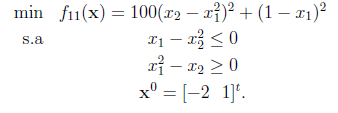

In [65]:
barrier_method(f1,x1,g1,(f,x,linear)->gradient_descent(f,x,linear,n_iter=500),newton,t=300)

(3.5066395743146755e-5, [1.002079492666194, 1.0036088539792365])

2.

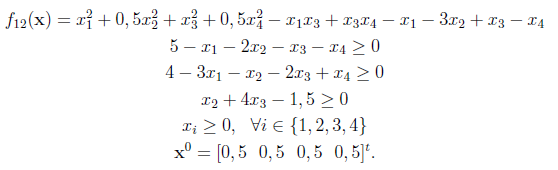

In [33]:
barrier_method(f2,x2,g2,newton_search,armijo)

(-4.68172223408539, [0.2727374658945035, 2.090876384025888, 3.67142487771465e-5, 0.5454014832968413])

3.

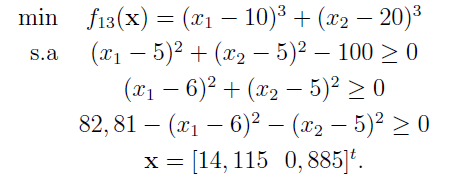

In [75]:
barrier_method(f3,x3,g3,newton_search,newton)

(-6961.813802875752, [14.095000031299115, 0.8429608538216018])

## Instâncias Método da Penalidade

1.



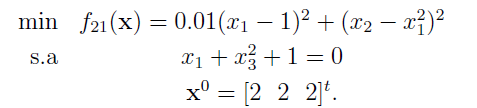

In [35]:
penality_method(f4,x4,h4,[],newton_search,armijo)

(0.039920119840199754, [-0.998001998001998, 0.99600798801598, 2.4314586365084114e-24])

2.

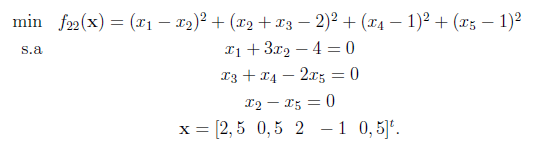



In [36]:
penality_method(f5,x5,h5,[],quasi_newton_BFGS,newton)

(3.4512664603419266e-31, [0.9999999999999998, 1.0, 0.9999999999999997, 1.0000000000000002, 1.0000000000000002])

3.

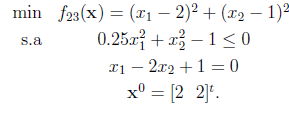



In [37]:
penality_method(f6,x6,h6,g6,quasi_newton_BFGS,secao_aurea)

(0.015524335384016067, [0.8237947044538988, 0.9115954459735927])

## Ambos os Métodos

1.

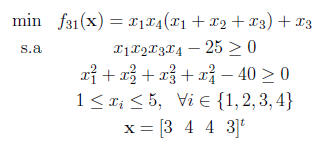


In [91]:
barrier_method(f7,x7,g7,quasi_newton_BFGS,newton)

(16.000099265018427, [1.0000174453450508, 4.999976082241852, 4.999818012764078, 1.0000252560280707])

In [39]:
penality_method(f7,x7,[],g7,quasi_newton_BFGS,armijo,p=4)

(15.99973856766942, [0.9999022126381514, 5.000117340918883, 5.000019553691205, 1.0000686947946014])

2.


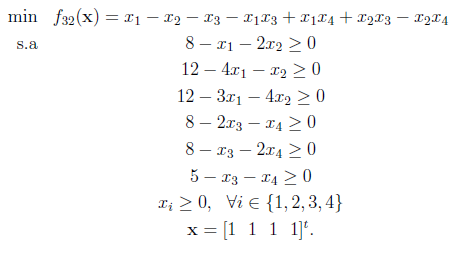

In [40]:
barrier_method(f8,x8,g8,gradient_descent,armijo)

(-14.999913487178183, [4.0780811140272565e-6, 2.9999942440262277, 6.448085102265769e-6, 3.9999918511597574])

In [41]:
penality_method(f8,x8,[],g8,gradient_descent,armijo,tol=1e-9,p=3)

(-15.000000001723823, [-1.62829122674867e-10, 3.0000000001279696, -6.513106214271318e-11, 4.000000000046522])

3.

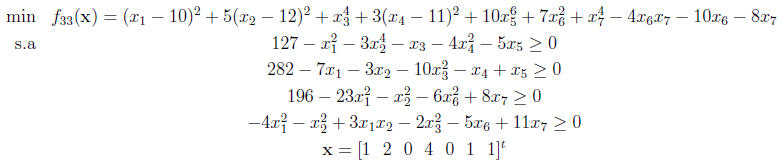

In [88]:
barrier_method(f9,x9,g9,(f,x,linear)->gradient_descent(f,x,linear,n_iter=1000),armijo)

(674.1390295538063, [2.465679335714826, 1.9753209346719036, -0.3282248111825475, 4.435084763984302, -0.621121046567633, 0.9520938424796459, 1.6895143166051672])

In [89]:
penality_method(f9,x9,[],g9,(f,x,linear)->gradient_descent(f,x,linear,n_iter=1000),armijo)

(674.1400600069386, [2.475421589145944, 1.9734934461136917, -0.34341888707112844, 4.438967626657365, -0.6214968094293873, 0.9465688823024578, 1.701683835261642])

#Referências
 $[1]$ **Ademir A.R.** e **Elizabeth W.K.** (2011). *Um Curso De Otimização. Curitiba.*